In [1]:
import struct
from struct import unpack
import PIL
from PIL import ImageDraw

%pylab inline
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
plt.style.use('seaborn-poster')
sns.set_palette('Set1', 10, desat=0.75)
sns.set(style='white', context='notebook', palette='deep')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def unpack_drawing(file_handle):
    key_id, = unpack('Q', file_handle.read(8))
    countrycode, = unpack('2s', file_handle.read(2))
    recognized, = unpack('b', file_handle.read(1))
    timestamp, = unpack('I', file_handle.read(4))
    n_strokes, = unpack('H', file_handle.read(2))
    image = []
    for i in range(n_strokes):
        n_points, = unpack('H', file_handle.read(2))
        fmt = str(n_points) + 'B'
        x = unpack(fmt, file_handle.read(n_points))
        y = unpack(fmt, file_handle.read(n_points))
        image.append((x, y))

    return {
        'key_id': key_id,
        'countrycode': countrycode,
        'recognized': recognized,
        'timestamp': timestamp,
        'image': image
    }


def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break

In [3]:
drawings = []
for drawing in unpack_drawings('data/full-binary-car.bin'):
    drawings.append(drawing)

In [4]:
drawings[0]

{'countrycode': b'PH',
 'image': [((187,
    173,
    85,
    56,
    14,
    7,
    0,
    0,
    9,
    23,
    42,
    68,
    183,
    216,
    248,
    255,
    254,
    247,
    219,
    207,
    186),
   (2,
    0,
    2,
    55,
    59,
    66,
    82,
    89,
    92,
    92,
    85,
    85,
    95,
    104,
    105,
    96,
    83,
    77,
    70,
    63,
    5)),
  ((65, 54, 52, 57, 67, 79, 86, 88, 79),
   (82, 91, 106, 121, 130, 131, 119, 100, 91)),
  ((191, 186, 185, 185, 188), (98, 103, 109, 116, 121))],
 'key_id': 4819414685843456,
 'recognized': 1,
 'timestamp': 1488334911}

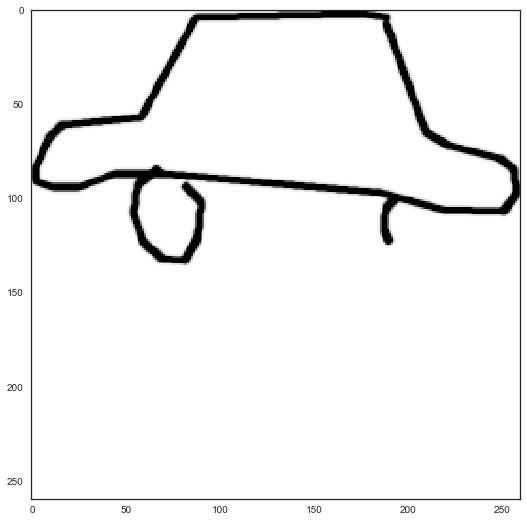

In [5]:
def drawing2array(drawing):
    # Original images are 255x255, add extra 2.5 to each edge.
    im = PIL.Image.new(mode='L', size=(260, 260))
    draw = PIL.ImageDraw.Draw(im)

    # Shift the strokes from edges by 2.5 pixels, convert them to valid format.
    shifted_strokes = [
        list(map(lambda x: tuple([i+2.5 for i in x]), tuple(zip(stroke[0], stroke[1]))))
        for stroke in drawing]
    
    # Draw wide half filled lines.
    for stroke in shifted_strokes:
        draw.line(stroke, fill=128, width=3)
    
    # Draw thin fully filled lines.
    for stroke in shifted_strokes:
        draw.line(stroke, fill=255, width=1)
    
    # Add some blur in order to smoothen the edges.
    im = im.filter(PIL.ImageFilter.GaussianBlur(1))
    # Clip max values to make core lines less blury.
    im = np.array(im)
    im = im.clip(0, int(im.max()/3))
    return im

im = drawing2array(drawings[0]['image'])
plt.figure(figsize=(9,9))
plt.imshow(im);

In [24]:
0.2*60

12.0

In [27]:
speed = 16000 / 12
50*1e6 / speed / 3600

10.416666666666666

In [23]:
def drawing2array(drawing):
    # Original images are 255x255, add extra 2.5 to each edge.
    im = PIL.Image.new(mode='L', size=(260, 260))
    draw = PIL.ImageDraw.Draw(im)

    # Shift the strokes from edges by 2.5 pixels, convert them to valid format.
    for stroke in drawing:
        stroke_shifted = list(map(lambda x: tuple([i+2.5 for i in x]), 
                                  tuple(zip(stroke[0], stroke[1])))
                             )
        draw.line(stroke_shifted, fill=255, width=3)

    im = im.resize((56, 56), resample=3)
    im = np.array(im)
    # Clip max values to make lines less blury.
    return im.clip(0, int(im.max()/2))


%timeit drawing2array(drawings[0]['image'])

1000 loops, best of 3: 546 µs per loop
